Provo a fare edge detection con Canny Edge Detection e Blob Detection di OpenCV

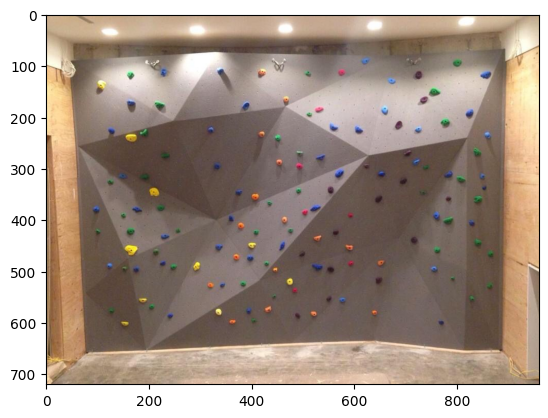

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Read the image from file
image = cv2.imread('climbing_wall.jpg')

# Display the image
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

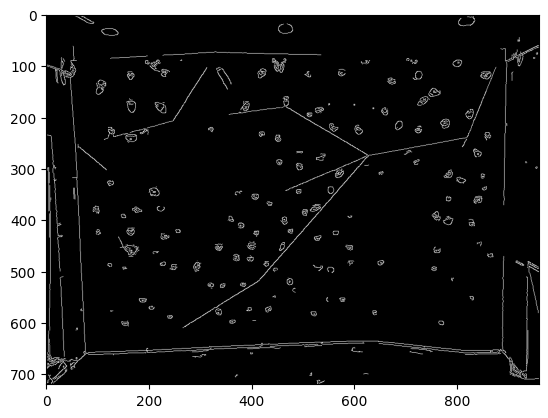

In [3]:

edges = cv2.Canny(image, 100, 200)
plt.imshow(edges, cmap='gray')
plt.show()

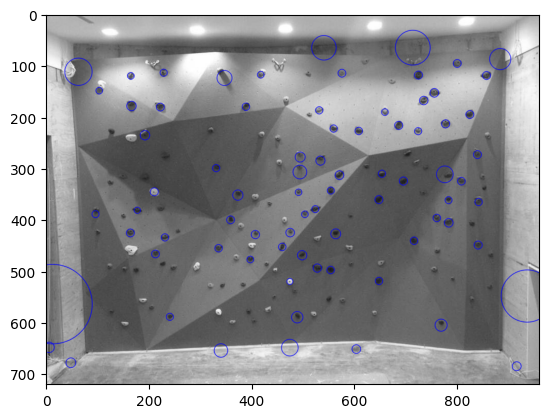

In [6]:

#image in grayscale
image_grey = cv2.imread('climbing_wall.jpg', cv2.IMREAD_GRAYSCALE)

params = cv2.SimpleBlobDetector_Params()

params.filterByArea = True
params.minArea = 100
params.filterByCircularity = False
params.filterByConvexity = False
params.filterByInertia = False

detector = cv2.SimpleBlobDetector_create(params)

keypoints = detector.detect(image_grey)

img_with_keypoints = cv2.drawKeypoints(image_grey, keypoints, np.array([]), (0, 0, 255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.imshow(img_with_keypoints)